In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

from collections import defaultdict
import math as math

In [38]:
meta_parameter = {
    'number of agents': 10,
    'number of resources': 5,
    'number of S scenario': 5,
    'number of T scenario': 10,
}

In [39]:
import random
def generate_scenario(meta_parameter):
    #S scenarios in second stage, T in extended stage
    n = meta_parameter['number of agents']

    S = meta_parameter['number of S scenario']
    T = meta_parameter['number of T scenario']
    scenario = {}

    pT=np.random.rand(S,T)
    pT=pT/sum(sum(pT))
    pT=pT.tolist()
    
    for j in range(S):
        scenario[j] = {}
        xS=[ random.uniform(0,0.6) for i in range(n)]
        scenario[j]['xi_1'] =  xS
        scenario[j]['prob'] = sum(pT[j])
        
        for k in range(T):
            xT=[ random.uniform(0,1) for i in range(n)]
            scenario[j][k]={'xi_2':xT,'prob':pT[j][k],'cond_prob':pT[j][k]/sum(pT[j])}
    return scenario 


scenario = generate_scenario(meta_parameter)


In [43]:
import pickle

with open('data', 'wb') as handle:
    pickle.dump(meta_parameter, handle)
    pickle.dump(scenario, handle)

In [5]:
print(scenario.keys())
print(scenario[0].keys())
print(scenario[0][0].keys())
print([scenario[i]['prob'] for i in range(5)])
print([scenario[0][i]['prob'] for i in range(10)])
print([scenario[0][i]['cond_prob'] for i in range(10)])

dict_keys([0, 1, 2, 3, 4])
dict_keys(['xi_1', 'prob', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys(['xi_2', 'prob', 'cond_prob'])
[0.19811185973145418, 0.16478844962349634, 0.1853453388864705, 0.25495623842705667, 0.19679811333152236]
[0.01079029011451963, 0.013336330249867944, 0.023709809089490174, 0.020275812208000014, 0.018509918225692777, 0.03429533619077431, 0.033258264154168465, 0.005572435132736774, 0.027671299276135024, 0.010692365090069057]
[0.05446564445534029, 0.06731717257081776, 0.11967889818221605, 0.1023452721885727, 0.09343165144572091, 0.17311096992003677, 0.16787618974073998, 0.028127721077831264, 0.1396751275448335, 0.05397135287389073]


In [5]:
import pickle
with open('data', 'rb') as handle:
    meta_parameter = pickle.load(handle)
    scenario = pickle.load(handle)

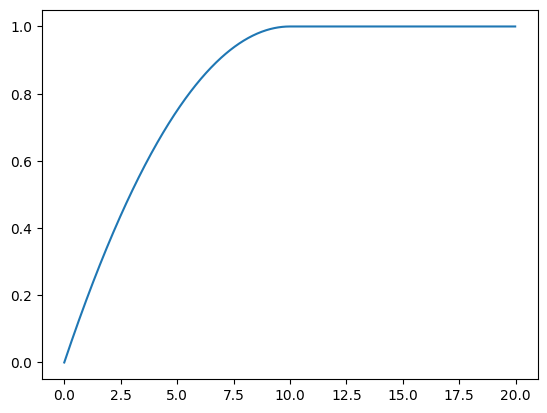

In [7]:
import numpy as np 
def evaluation(x, alpha):
    if (x<=alpha/2):
        return 4*((x/alpha) - (x/alpha)**2)
    else:
        return 1

import matplotlib.pyplot as plt


x = np.arange(0,20,0.025)
y = np.array([ evaluation(_,20) for _ in x])
plt.figure()
plt.plot(x, y, color='tab:blue')
plt.show()

Solving the problem with stochastic dominant constraints

If benchmark is none, then solve the risk-neutral problem

In [3]:
from gurobipy import quicksum as qsum

def subproblem(x_s, meta_parameter, scenario_s, bm_s = None):
    n = meta_parameter['number of agents']
    K = meta_parameter['number of resources']

    S = meta_parameter['number of S scenario']
    T = meta_parameter['number of T scenario']
    
    alpha = 2*K
    reallo_cost = 0.01
    
    w_s = sum(evaluation(scenario_s['xi_1'][i]*x_s[i], alpha) for i in range(n))
    
    scenario_extended = {}

    for t in range(T):
        scenario_extended[t] = [scenario_s[t]['xi_2'][i]*(1-scenario_s['xi_1'][i])\
             for i in range(n)]
        
    prob_extended_list = [ scenario_s[j]['cond_prob'] for j in range(T)]

    sp = gp.Model("subproblem")
    
    z = sp.addVars(n,n, vtype=GRB.CONTINUOUS, name="z", lb=list(np.zeros((n,n)))) #reallocate
    y = sp.addVars(n,   vtype=GRB.CONTINUOUS, name="y", lb=list(np.zeros(n))) #new resources

    
    # conditional probability of extended stage, conditioning on S
    extended_obj = {}
    for t in range(T):
        extended_obj[t] = qsum(4*((scenario_extended[t][i]*y[i]/alpha) - \
                                    (scenario_extended[t][i]*y[i]/alpha)**2)  for i in range(n)) 
    extended_obj_exp = qsum(extended_obj[t]*prob_extended_list[t] for t in range(T))

    obj = w_s + extended_obj_exp  - reallo_cost*z.sum()
    sp.setObjective( obj, GRB.MAXIMIZE)

    reallocate = sp.addConstrs( (y[i] == (1-scenario_s['xi_1'][i])*x_s[i] +\
                                     z.sum('*',i)-z.sum(i,'*') for i in range(n)), \
                                    name = 'reallocate')

    sp.setParam('OutputFlag', 0)
    sp.setParam('QCPDual', 1)
    

    max_it = 1e2
    it = 0

 
    if bm_s is None:
        sp.optimize()
        # print(sp.status)
        if sp.status == GRB.OPTIMAL:
            
            feas = 1
            
            lmbd = [reallocate[i].Pi for i in range(n)]
            
            cut_subdiff = [lmbd[i]*(1-scenario_s['xi_1'][i]) + 4*(1-2*(scenario_s['xi_1'][i]/alpha)*x_s[i])\
                *(scenario_s['xi_1'][i]/alpha) for i in range(n)]
            
            obj_val = obj.getValue()
            val_t = [extended_obj[t].getValue() for t in range(T)]
            print(obj_val, cut_subdiff)
            return cut_subdiff, feas, obj_val, val_t
        else:
            raise Exception('risk neutral subproblem is infeasible')
    # if given a benchmark, then add in event cut 
    else:

        value_list_b = [ bm_s['r_s'] + bm_s[t]['r_t'] for t in range(T) ]
        # short_fall_b = {}
        # for t in range(T):
        #     short_fall_b[t] =  sum(bm_s[tt]['cond_prob']*max(value_list_b[t] - value_list_b[tt],0) \
        #                                                 for tt in range(T))
        shtf = sp.addVars(T, T, vtype=GRB.CONTINUOUS, name="shtf", lb=list(np.zeros((T,T))))
        shtf_def = sp.addConstrs( (shtf[t, tt] >= value_list_b[t] - w_s +\
             reallo_cost*z.sum()- extended_obj[tt] for t in range(T)\
                 for tt in range(T)), name = 'shtf_def')
        
        #Write order constraint as T ineq constr: E[(eta-X)+]<=E[(eta-Y)+], for eta=Y(\omega_1), ...
        
        #expected shortfall of benchmark: E[(eta_t - Y)+]
        exp_shtf_bm = [sum(prob_extended_list[tt] * max(0,value_list_b[t]-value_list_b[tt]) for tt in range(T)) for t in range(T)]
        
        prob_extended_edit = dict( [((t,tt),prob_extended_list[tt]) for tt in range(T) for t in range(T)] )
        
        ord_constr = sp.addConstrs( (shtf.prod(prob_extended_edit, t, '*') <= exp_shtf_bm[t] for t in range(T)), name = 'ord_constr' )
        sp.optimize()
        if sp.status == GRB.OPTIMAL:
            short_fall = {}
            for t in range(T):
                short_fall[t] = sum(bm_s[tt]['cond_prob']*max(value_list_b[t]-\
                    w_s-extended_obj[tt].getValue() ,0) for tt in range(T))
            # print(sp.status)

            lmbd = [reallocate[i].Pi for i in range(n)]
            
            cut_subdiff = [lmbd[i]*(1-scenario_s['xi_1'][i]) + 4*(1-2*(scenario_s['xi_1'][i]/alpha)*x_s[i])\
                *(scenario_s['xi_1'][i]/alpha) for i in range(n)]
            
            obj_val = obj.getValue()
            val_t = [extended_obj[t].getValue() for t in range(T)]

            return cut_subdiff, 1, obj_val, val_t

                
        elif (sp.status == GRB.INFEASIBLE) or (sp.status == GRB.INF_OR_UNBD):
            
            sp.remove(reallocate)
            
            u = sp.addVars(n, vtype=GRB.CONTINUOUS, name="u", lb = -GRB.INFINITY)
            u_abs = sp.addVars(n, vtype=GRB.CONTINUOUS, name="u_abs")
            
            reallocate_again = sp.addConstrs( (u[i] + y[i] == (1-scenario_s['xi_1'][i])*x[i] + z.sum('*',i)-z.sum(i,'*') for i in range(n)),\
                                                name = 'reallocate_again')
            
            abs_of_u = sp.addConstrs( (u[i] <= u_abs[i] for i in range(n)) , name = 'abs_of_u')
            abs_of_u_ = sp.addConstrs( (-u[i] <= u_abs[i] for i in range(n)) , name = 'abs_of_u_')
            
            obj_feas = qsum(u_abs)
            sp.setObjective(obj_feas, GRB.MINIMIZE)
            
            sp.optimize()
            if sp.status != GRB.OPTIMAL:
                raise Exception(f'feasible subproblem status code {sp.status}')

            cut_val = obj_feas.getValue()
            # cut_val = sp.ObjVal
            
            lmbd = [reallocate_again[i].Pi for i in range(n)]
            
            
            cut_subdiff = [lmbd[i]*(1-scenario_s['xi_1'][i]) +\
                    4*(1-2*(scenario_s['xi_1'][i]/alpha)*x[i])*(scenario_s['xi_1'][i]/alpha) for i in range(n)]
            
            
            return cut_subdiff, 0, cut_val, [-float('inf') for i in range(T)]
        raise Exception(f'subproblem stopped due to statuse code {sp.status})')

In [10]:

x_start = [ 1 for i in range(meta_parameter['number of agents'])]
print(subproblem( x_start, meta_parameter, scenario[0]))

1.4873887113285087 [0.31517090166059347, 0.5213291061728912, 0.46317252662691377]
([0.31517090166059347, 0.5213291061728912, 0.46317252662691377], 1, 1.4873887113285087, [0.8125192671837397, 0.9761227359129018, 0.5894806837302715])


In [9]:
scenario[0]

{'xi_1': [0.052635313546920456, 0.5098652675622277, 0.33248895824861213],
 'prob': 0.25599837531142505,
 0: {'xi_2': [0.6604385017619175, 0.6039500460941947, 0.38346317550284725],
  'prob': 0.09906173712642562,
  'cond_prob': 0.3869623664834429},
 1: {'xi_2': [0.9980540737628484, 0.5539333587372145, 0.3108404365129557],
  'prob': 0.011185969396687397,
  'cond_prob': 0.04369547026647936},
 2: {'xi_2': [0.16514006523761038, 0.8908134569146171, 0.12463044013450042],
  'prob': 0.14575066878831205,
  'cond_prob': 0.5693421632500778}}

In [77]:
def masterproblem(x_start, meta_parameter, scenario, bm = None, max_it = 1e2):
    n = meta_parameter['number of agents']
    K = meta_parameter['number of resources']

    S = meta_parameter['number of S scenario']
    T = meta_parameter['number of T scenario']
    
    # if bm is none we consider risk-neutral solution
    if bm is None:
        bm = [None for i in range(S)]
    
    # nvm
    # assert S == len(scenario)-1, f" S not equal:"
    # assert T == len(scenario[0][0]), f"T not equal"

    prob_s = [ scenario[s]['prob'] for s in range(S)]
    
    prob_s_dict = dict([(s, prob_s[s]) for s in range(S)])
    
    mp=gp.Model("masterproblem")
    
    x = mp.addVars(n, vtype=GRB.CONTINUOUS, name="x", lb=list(np.zeros(n)))
    v = mp.addVars(S, vtype=GRB.CONTINUOUS, name="v", lb=-GRB.INFINITY, ub=[100 for i in range(S)])
    
    v_exp = v.prod(prob_s_dict)
    
    mp.setObjective(v_exp, GRB.MAXIMIZE)
    
    mp.addConstr( x.sum() <= K )
    
    mp.setParam('OutputFlag', 0)
    
    it = 0 #iteration
    
    x_it = x_start #n*1 vector
    cuts = {}
    i_cut = 0
    while (it<max_it):
        # print('it', it)
        optm_sec_stage = [0 for i in range(S)]
        
        feas_sec_stage = True
        
        v_t = []
        #obj cut & feas cut
        for s in range(S):
            # print('S',s)
            subdiff, feas, val, val_t = subproblem(x_it, meta_parameter, scenario[s], bm_s=bm[s])

            if feas==1:
                subdiff_dict = dict([(i,subdiff[i]) for i in range(n)])
                cuts[i_cut] = mp.addConstr( v[s] <= val + x.prod(subdiff_dict) - sum(subdiff[i]*x_it[i]\
                     for i in range(n)) )
                optm_sec_stage[s] = val
                # print("\n add a objective cut for scenario", 'it:', it, 'scenario' ,s, "\n")
                
                i_cut += 1
            elif feas==0:
                subdiff_dict = dict([(i,subdiff[i]) for i in range(n)])
                mp.addConstr( val + x.prod(subdiff_dict) - sum(subdiff[i]*x_it[i] for i in range(n)) <= 0 )
                
                feas_sec_stage = False
                optm_sec_stage[s] = -float('inf')
                print("\n add a feasbility cut for scenario", 'it:', it, 'scenario' ,s, "\n")
            v_t.append(val_t)
        
        mp.optimize()
        # print(mp.display())
        if mp.status != GRB.OPTIMAL:
            raise Exception(f'master problem status code {mp.status}')
        x_it_ = x_it
        x_it = [x[i].x for i in range(n)]
        
        if feas_sec_stage == False:
            it = it + 1
            continue;
        if sum([abs(x_it_[i]-x_it[i]) for i in range(n)])<0.1:
            break
             
        
        stop_crit = sum(abs(optm_sec_stage[s]-v[s].X) for s in range(S))
        
        # print(optm_sec_stage)
        # print([v[s].x for s in range(S)])
        if ( stop_crit < 1e-5 ):
            break;    
            
        it = it + 1
       
    if it<max_it:
        print(it)
        return x_it, [v[s].x for s in range(S)], v_t
    else:
        raise Exception('pre-mature as max iteration number reached at master problem')

In [51]:
meta_parameter = {
    'number of agents': 3,
    'number of resources': 2,
    'number of S scenario': 3,
    'number of T scenario': 3,
}
scenario = generate_scenario(meta_parameter)
with open('data', 'wb') as handle:
    pickle.dump(meta_parameter, handle)
    pickle.dump(scenario, handle)


In [53]:
scenario

{0: {'xi_1': [0.052635313546920456, 0.5098652675622277, 0.33248895824861213],
  'prob': 0.25599837531142505,
  0: {'xi_2': [0.6604385017619175, 0.6039500460941947, 0.38346317550284725],
   'prob': 0.09906173712642562,
   'cond_prob': 0.3869623664834429},
  1: {'xi_2': [0.9980540737628484, 0.5539333587372145, 0.3108404365129557],
   'prob': 0.011185969396687397,
   'cond_prob': 0.04369547026647936},
  2: {'xi_2': [0.16514006523761038, 0.8908134569146171, 0.12463044013450042],
   'prob': 0.14575066878831205,
   'cond_prob': 0.5693421632500778}},
 1: {'xi_1': [0.03210459151203011, 0.5893292714867927, 0.5170235193991009],
  'prob': 0.47864414899823665,
  0: {'xi_2': [0.8529534668573152, 0.47900476433382455, 0.8149691542186155],
   'prob': 0.14771756475479425,
   'cond_prob': 0.30861667287473404},
  1: {'xi_2': [0.04402236025626938, 0.0615265169898187, 0.27885806211402075],
   'prob': 0.1615429334655796,
   'cond_prob': 0.3375011139354275},
  2: {'xi_2': [0.6192810102342031, 0.1322568441173

In [75]:
def generate_x_start(meta_parameter):
    n = meta_parameter['number of agents']
    K = meta_parameter['number of resources']

    S = meta_parameter['number of S scenario']
    T = meta_parameter['number of T scenario']
    val = float(K-1)/float(n)
    return [ 0.5 for i in range(n)]
    
x_start = generate_x_start(meta_parameter)
print(x_start)
x, val_s, val_t = masterproblem(x_start, meta_parameter, scenario)
print(x)
print(val_s)

[0.5, 0.5, 0.5]
0.7906592731936067 [0.35895566557163117, 0.6080103999492656, 0.5203500915906076]
0.9010190303506241 [0.34538313544125027, 0.6314263725836233, 0.601818921236176]
0.9121347010044697 [0.575205385682559, 0.5940181138935462, 0.49894517316521775]
1.1022794900674622 [0.3729425015282552, 0.41071753427435875, 0.5552792241643898]
1.1614125849273578 [0.36354590265521186, 0.37854162480851705, 0.6797573463682407]
1.1364391717288858 [0.6041522546510896, 0.43189589834899056, 0.5058891168462467]
1.1545679270836093 [0.3624626484701709, 0.5001691193721315, 0.5058568910276828]
1.294573233920913 [0.355356714415966, 0.4952694872689145, 0.5809792135285292]
1.1526792967136428 [0.6003490566157316, 0.4990843110739247, 0.4758269762596269]
1.132672463890392 [0.35877542879217744, 0.5653167142327324, 0.4747436997487506]
1.29777860716209 [0.3492534020339669, 0.5822654150436273, 0.508982392299488]
1.1227207633440464 [0.5978639337017209, 0.5494754883992087, 0.4565882933038701]
1.1498276153910352 [0.36

In [34]:
def generate_bm(meta_parameter,scenario, val_s, val_t):
    n = meta_parameter['number of agents']
    K = meta_parameter['number of resources']

    S = meta_parameter['number of S scenario']
    T = meta_parameter['number of T scenario']
    bm = {}
    for s in range(S):
        bm[s] = {}
        bm[s]['r_s'] = val_s[s]
        for t in range(T):
            bm[s][t] = {}
            bm[s][t]['cond_prob'] =  scenario[s][t]['cond_prob']
            bm[s][t]['r_t'] = val_t[s][t]
    return bm
bm = generate_bm(meta_parameter,scenario, val_s, val_t)

In [35]:
bm

{0: {'r_s': 1.1993735372157852,
  0: {'cond_prob': 0.41509060360333666, 'r_t': 0.877168249261907},
  1: {'cond_prob': 0.33418098239813876, 'r_t': 0.4098103032649095},
  2: {'cond_prob': 0.2507284139985246, 'r_t': 0.8775729861165739}},
 1: {'r_s': 1.174206518034151,
  0: {'cond_prob': 0.022015590157035813, 'r_t': 0.27627135476222975},
  1: {'cond_prob': 0.48206598735458306, 'r_t': 0.6301980761383732},
  2: {'cond_prob': 0.495918422488381, 'r_t': 0.8861197988045217}},
 2: {'r_s': 1.141801052737846,
  0: {'cond_prob': 0.8083895258178214, 'r_t': 0.31574132866023796},
  1: {'cond_prob': 0.04167636526715933, 'r_t': 0.4555375478526516},
  2: {'cond_prob': 0.14993410891501946, 'r_t': 0.4402967643755436}}}

In [80]:
print(x_start)
x, val_s, val_t = masterproblem(x_start, meta_parameter, scenario,bm)
print(x)
print(val_s)

[0.5, 0.5, 0.5]

 add a feasbility cut for scenario it: 0 scenario 0 


 add a feasbility cut for scenario it: 0 scenario 1 



Exception: subproblem stopped due to statuse code 12)

In [70]:
from gurobipy import quicksum as qsum

def subproblem_shift(x_s, meta_parameter, scenario_s, bm_s, penalty_shit = 0.01):
    n = meta_parameter['number of agents']
    K = meta_parameter['number of resources']

    S = meta_parameter['number of S scenario']
    T = meta_parameter['number of T scenario']
    
    alpha = 2*K
    reallo_cost = 0.01
    penalty_shit = 0.01
    # w_s = sum(4*((scenario_s['xi_1'][i]*x_s[i]/alpha) - \
    #                 (scenario_s['xi_1'][i]*x_s[i]/alpha)**2)  for i in range(n))
    w_s = sum(evaluation(scenario_s['xi_1'][i]*x_s[i], alpha) for i in range(n))
    scenario_extended = {}
    for t in range(T):
        scenario_extended[t] = [scenario_s[t]['xi_2'][i]*(1-scenario_s['xi_1'][i]) for i in range(n)]
        
    prob_extended_list = [ scenario_s[j]['cond_prob'] for j in range(T)]

    sp = gp.Model("subproblem")
    
    z = sp.addVars(n,n, vtype=GRB.CONTINUOUS, name="z", lb=list(np.zeros((n,n)))) #reallocate
    y = sp.addVars(n,   vtype=GRB.CONTINUOUS, name="y", lb=list(np.zeros(n))) #new resources
    # shift = sp.addVar( vtype=GRB.CONTINUOUS, name="shift", lb=0)
    shift = sp.addVar(vtype=GRB.CONTINUOUS, name="shift", lb=-GRB.INFINITY)

    
    #conditional probability of extended stage, conditioned by scenario s at second stage
    extended_obj = {}
    for t in range(T):
        extended_obj[t] = shift + qsum(4*((scenario_extended[t][i]*y[i]/alpha) - \
                                    (scenario_extended[t][i]*y[i]/alpha)**2)  for i in range(n)) 
    extended_obj_exp = qsum(extended_obj[t]*prob_extended_list[t] for t in range(T))

    obj = w_s- penalty_shit*shift + extended_obj_exp  - reallo_cost*z.sum()
    sp.setObjective( obj, GRB.MAXIMIZE)

    reallocate = sp.addConstrs( (y[i] == ((1-scenario_s['xi_1'][i])*x_s[i] + z.sum('*',i)-z.sum(i,'*')) for i in range(n)), \
                                    name = 'reallocate')

    sp.setParam('OutputFlag', 0)
    sp.setParam('QCPDual', 1)
    sp.setParam('BarQCPConvTol', 1e-7)
    # tolerance = 1e-2

    max_it = 1e2
    it = 0

    value_list_b = [ bm_s['r_s'] + bm_s[t]['r_t'] for t in range(T) ]
    shtf = sp.addVars(T, T, vtype=GRB.CONTINUOUS, name="shtf", lb=list(np.zeros((T,T))))
    shtf_def = sp.addConstrs( (shtf[t, tt] >= value_list_b[t] - shift \
        -w_s - extended_obj[tt] + reallo_cost*z.sum() \
              for t in range(T) for tt in range(T)), name = 'shtf_def')
    
    exp_shtf_bm = [sum(prob_extended_list[tt] * max(0,value_list_b[t]-value_list_b[tt])\
         for tt in range(T)) for t in range(T)]
    
    prob_extended_edit = dict( [((t,tt),prob_extended_list[tt])\
         for tt in range(T) for t in range(T)] )
    
    ord_constr = sp.addConstrs( (shtf.prod(prob_extended_edit, t, '*') \
        <= exp_shtf_bm[t] for t in range(T)), name = 'ord_constr' )
    
    sp.optimize()
    try:
        lmbd = [reallocate[i].Pi for i in range(n)]
            
        cut_subdiff = [lmbd[i]*(1-scenario_s['xi_1'][i]) + 4*(1-2*(scenario_s['xi_1'][i]/alpha)*x_s[i])\
            *(scenario_s['xi_1'][i]/alpha) for i in range(n)]
        
        obj_val = obj.getValue()
        val_t = [extended_obj[t].getValue() for t in range(T)]

        return cut_subdiff, 1, obj_val, val_t, shift.X
    except:
        raise Exception(f'subproblem event cut status code {sp.status})')
    

    # short_fall_b = {}
    # for t in range(T):
    #     short_fall_b[t] =  sum(bm_s[tt]['cond_prob']*max(value_list_b[t] - value_list_b[tt],0) \
    #                                                 for tt in range(T))
    # while(it < max_it):
    #     sp.optimize()
    #     if sp.status == GRB.OPTIMAL:
    #         short_fall = {}
    #         for t in range(T):
    #             short_fall[t] = sum(bm_s[tt]['cond_prob']*max(value_list_b[t]-\
    #                 w_s-extended_obj[tt].getValue() ,0) for tt in range(T))
        
    #         all_sat_flag = True
    #         for t in range(T):
    #             if short_fall[t]>short_fall_b[t] + tolerance:
    #                 print('event_cut')
    #                 all_sat_flag = False
    #                 A = [tt for tt in range(T) if w_s + extended_obj[tt].getValue()<value_list_b[t]]
    #                 a = qsum( bm_s[d]['cond_prob']*(value_list_b[t]-w_s-extended_obj[d]) for d in A)
    #                 sp.addConstr( a<=short_fall_b[t], name= f'event_cut_{it}_{short_fall_b[t]}')
            
    #         if not all_sat_flag:
    #             it += 1
    #             continue

    #         lmbd = [reallocate[i].Pi for i in range(n)]
            
    #         cut_subdiff = [lmbd[i]*(1-scenario_s['xi_1'][i]) + 4*(1-2*(scenario_s['xi_1'][i]/alpha)*x_s[i])\
    #             *(scenario_s['xi_1'][i]/alpha) for i in range(n)]
            
    #         obj_val = obj.getValue()
    #         val_t = [extended_obj[t].getValue() for t in range(T)]

    #         return cut_subdiff, 1, obj_val, val_t, shift.X
    #     else:
    #         raise Exception(f'subproblem event cut status code {sp.status})')
    # raise Exception(f'subproblem pre-mature( max iteration {max_it})')

In [67]:
def masterproblem_shift(x_start, meta_parameter, scenario, bm, \
                                    max_it = 1e2, penalty_shit = 0.01):
    n = meta_parameter['number of agents']
    K = meta_parameter['number of resources']

    S = meta_parameter['number of S scenario']
    T = meta_parameter['number of T scenario']
    


    # if bm is none we consider risk-neutral solution
    if bm is None:
        bm = [None for i in range(S)]
    
    # nvm
    # assert S == len(scenario)-1, f" S not equal:"
    # assert T == len(scenario[0][0]), f"T not equal"

    prob_s = [ scenario[s]['prob'] for s in range(S)]
    
    prob_s_dict = dict([(s, prob_s[s]) for s in range(S)])
    
    mp=gp.Model("masterproblem")
    
    x = mp.addVars(n, vtype=GRB.CONTINUOUS, name="x", lb=list(np.zeros(n)))
    v = mp.addVars(S, vtype=GRB.CONTINUOUS, name="v", lb=-GRB.INFINITY, ub=[100 for i in range(n)])
    
    v_exp = v.prod(prob_s_dict)
    
    mp.setObjective(v_exp, GRB.MAXIMIZE)
    
    mp.addConstr( x.sum() <= K )
    
    mp.setParam('OutputFlag', 1)
    
    it = 0 #iteration
    
    x_it = x_start #n*1 vector
    cuts = {}
    i_cut = 0
    shift = [0 for i in range(S)]
    while (it<max_it):
        print('it', it)
        optm_sec_stage = [0 for i in range(S)]
        
        feas_sec_stage = True
        
        v_t = []
        #obj cut & feas cut
        for s in range(S):
            print('S',s)
            subdiff, feas, val, val_t, shift[s] = subproblem_shift(x_it, meta_parameter, scenario[s], 
                                                                bm[s], penalty_shit)

            if feas==1:
                subdiff_dict = dict([(i,subdiff[i]) for i in range(n)])
                cuts[i_cut] = mp.addConstr( v[s] <= val + x.prod(subdiff_dict) - sum(subdiff[i]*x_it[i]\
                     for i in range(n)) )
                optm_sec_stage[s] = val
                # print("\n add a objective cut for scenario", 'it:', it, 'scenario' ,s, "\n")
                
                i_cut += 1
            elif feas==0:
                subdiff_dict = dict([(i,subdiff[i]) for i in range(n)])
                mp.addConstr( val + x.prod(subdiff_dict) - sum(subdiff[i]*x_it[i] for i in range(n)) <= 0 )
                
                feas_sec_stage = False
                optm_sec_stage[s] = -float('inf')
                print("\n add a feasbility cut for scenario", 'it:', it, 'scenario' ,s, "\n")
            v_t.append(val_t)
        
        mp.optimize()
        print(mp.display())
        if mp.status != GRB.OPTIMAL:
            raise Exception(f'master problem status code {mp.status}')
        x_it = [x[i].x for i in range(n)]
        
        if feas_sec_stage == False:
            it = it + 1
            continue
             
        
        stop_crit = sum(abs(optm_sec_stage[s]-v[s].x) for s in range(S))
        
        # print(optm_sec_stage)
        # print([v[s].x for s in range(S)])
        if ( stop_crit < 1e-3 ):
            break;    
            
        it = it + 1
    if it<max_it:
        return x_it, [v[s].x for s in range(S)], v_t, shift
    else:
        print('pre-mature as max iteration number reached')
        return x_it, [v[s].x for s in range(S)], v_t, shift

In [71]:
print(x_start)
x, val_s, val_t,shift = masterproblem_shift(x_start, meta_parameter, scenario,bm, 20)
print(x)

print(shift)

[1, 1, 1]
it 0
S 0


Exception: subproblem event cut status code 12)

In [ ]:
[0.6224035485546917, -1.9475850163533446, -0.636754857307265]
[0.43909448293787534, 0.18540771582770788, -0.1681962526317875]

[2.0, 0.0, 0.0]
[0.6224035485546917, -1.9475850163533446, -0.636754857307265]
[1.1941566880653482, 0.5566422066061136, 0.4357746714843529]

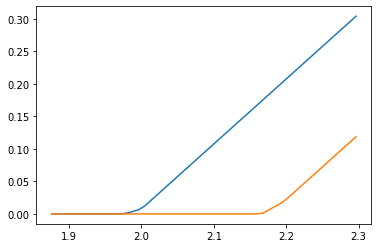

In [ ]:
#F^{(2)} at first stage
import numpy as np
import matplotlib.pyplot as plt

prob_first_stage = [sum(scenario[0][s][t][2] for t in range(T)) for s in range(S)]

v_bm_p = [[v_bm[s], prob_first_stage[s]] for s in range(S)]
v_bm_p.sort()

v_ssd_p = [[v_ssd[s], prob_first_stage[s]] for s in range(S)]
v_ssd_p.sort()

x_min = min(min([v_bm,v_ssd])) - 0.1
x_max = max(max([v_bm,v_ssd])) + 0.1
x_axis = np.linspace(x_min,x_max,50)

y_axis_bm = [sum(v_bm_p[s][1]*max(0,(x-v_bm_p[s][0])) for s in range(S)) for x in x_axis]

y_axis_ssd = [sum(v_ssd_p[s][1]*max(0,(x-v_ssd_p[s][0])) for s in range(S)) for x in x_axis]

plt.figure()
plt.plot(x_axis, y_axis_bm, color='tab:blue') #benchmark
plt.plot(x_axis, y_axis_ssd, color='tab:orange')

In [ ]:
v_bm,v_ssd, x_bm, x_ssd

([0.72, 0.72, 0.72],
 [0.7533917736278078, 0.7311509345550185, 0.72],
 [5.0, 0.0, 0.0],
 [4.099196689941724, 0.0, 0.9008033100582757])

In [ ]:
#m = gp.Model("m")
#x = m.addVar(vtype=GRB.CONTINUOUS, name="x", lb=0)
#y = m.addVar(vtype=GRB.CONTINUOUS, name="y", lb=0)
#m.setObjective(x-y, GRB.MINIMIZE)
#m.addConstr((x==1)>>(y-2*x<=0), name = "quad")
#m.addConstr((x==0)>>(y+x==0), name = "constant")
#m.optimize()

In [ ]:
a=[3+i for i in range(3)]
[a[i]*0.8 for i in range(len(a))]

[2.4000000000000004, 3.2, 4.0]

In [ ]:
def func(x):
    return x, x**2

(a,_) = func(2)
a

2

In [ ]:
ab = (np.ones(3)).tolist()
#ab = ab.tolist()
ab

[1.0, 1.0, 1.0]

In [ ]:
for i in range(0,3):
    print(i)

0
1
2
